# Task 2

This is the second task for the 'Practical Course Data Science' (M.Inf.1800). In this task you will tackle your first real data science problem with sort of big data: given a list of taxi rides, the goal is to predict the price of each taxi ride.

In [1]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

In [2]:
# read data in memory
data = pd.read_csv("train.csv")

## Clean Data

Clean the data.
Remove all obvious outliers:
* Invalid Ratecoded (must be in range 1,2,3,4,5,6)
* Invalid improvement_surcharge (only .5 is valid!)
* Invalid mta_tax (either 0 or .5)
* Invalid extra (0,0.5,1,1.5,4.5)
* All negative values (costs can't be negative!)
* Drop useless information
    * store_and_fwd_flag (Useless)
    * Vendor ID (Useless)
    * Improvement surcharge (Fixed value!)
* Calculate total amount, drop outliers (values which doesnt equal to the total amount must be wrong!)
* Save pickup and dropoff time as datetime object

In [3]:
# Drop all data with invalid extra, improvement_surcharge, RatecodeID, mta_tax -> Invalid!
df = data.drop(data[data.extra.isin([0,0.5,1,1.5,4.5]) == False].index)
df = df.drop(df[df.improvement_surcharge!=0.3].index)
# Also drop 6 -> No group rides in test data!
df = df.drop(df[df.RatecodeID.isin([1,2,3,4,5]) == False].index)
df = df.drop(df[df.mta_tax.isin([0,0.5]) == False].index)

# Also drop negative values:
df = df.drop(df[df.tip_amount < 0].index)
df = df.drop(df[df.fare_amount < 0].index)
df = df.drop(df[df.total_amount < 0].index)
df = df.drop(df[df.tolls_amount < 0].index)
df = df.drop(df[df.trip_distance < 0].index)

# Drop useless columns
df = df.drop(['VendorID','store_and_fwd_flag','improvement_surcharge'],axis=1)

# drop invalid rush hour surtaxes
df = df.drop(df[(df.RatecodeID !=2) & (df.extra == 4.5)].index)
df = df.drop(df[(df.RatecodeID ==2) & (df.extra == 1)].index)
df = df.drop(df[(df.RatecodeID ==3) & (df.mta_tax == .5)].index)
df = df.drop(df[(df.RatecodeID.isin([2,4,5])) & (df.mta_tax == 0)].index)

In [4]:
df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [5]:
total = df.extra+df.tip_amount+df.tolls_amount+df.mta_tax+df.fare_amount + 0.3
df = df.drop(df[df.total_amount != total].index)

Add duration

In [6]:
'''
Add duration element: How long was the trip
'''
# Get duration
df['duration'] = pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"])

#drop all negative and too short rides  (< 30s , 40s is lowest in test data!)
df = df.drop(df[df.duration < pd.Timedelta("30 seconds")].index)

# drop all > 3h (unreasonable long, 2:30 is longest in test data)
df = df.drop(df[df.duration > pd.Timedelta("3 hours")].index)

Remove outliers.
Check each category and remove all values which are more than 5 stds away!

In [7]:
#keep only the ones that are within +5 to -5 standard deviations in the column 'Data'.
feats = ['tip_amount','total_amount','fare_amount','trip_distance']
for feat in feats:
    df = df[np.abs(df[feat]-df[feat].mean())<=5*df[feat].std()] 

Add important features for prediction and value calculation:
* Day -  Day of the week. Maybe useful for tip prediction. Used to calculate rush hour, as Rush Hour is only on Weekdays!
* Holiday - Boolean, if its a holiday. On Holidays are no Rush hours!
* Overnight - Boolean tag, if the trip was an overnight trip
* Rush Hour - Boolean tag, if the trip was an rush hour trip
* Pickup time - Time tag, when the trip started
* Dropoff time - Time tag, wehen the trip ended
* Mean time - Time tag, middle in the trip

In [8]:
'''
Add a weekday element
'''
df['day'] = (pd.to_datetime(df['tpep_pickup_datetime']).dt.weekday_name)

In [9]:
# Get Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = pd.date_range(start=df['tpep_pickup_datetime'].min(), end=df['tpep_pickup_datetime'].max())
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['tpep_pickup_datetime'].isin(holidays)

In [10]:
df['day'].value_counts()

Thursday     1591789
Wednesday    1537048
Saturday     1323796
Friday       1305178
Tuesday      1199303
Monday       1142575
Sunday       1114760
Name: day, dtype: int64

In [11]:
df['day'] = df.day.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')

In [12]:
df['meanDate'] = (  pd.to_datetime(df['tpep_pickup_datetime']) \
 + ((pd.to_datetime(df['tpep_dropoff_datetime'])-pd.to_datetime(df['tpep_pickup_datetime']))/2) \
)

In [13]:
df['time']= df.meanDate - pd.to_datetime(df.meanDate.dt.date)

In [14]:
df['pickup_time'] = df.tpep_pickup_datetime - pd.to_datetime(df.tpep_pickup_datetime.dt.date)

In [15]:
df['dropoff_time'] = df.tpep_dropoff_datetime - pd.to_datetime(df.tpep_dropoff_datetime.dt.date)

Check for overlapping Overnight and Rushhours (should be 1.5 tax)

As there is no overlapping, all 1.5 taxes have to be invalid -> Remove!

In [75]:
df = df.drop(df[df.extra == 1.5].index)

## Clean obvious errors

In [76]:
df.extra.value_counts()

0.0    4608572
0.5    3163609
1.0    1430866
4.5      11385
Name: extra, dtype: int64

In [77]:
# Rush Hour on Weekends
df = df.drop(df[(df.extra.isin([1,4.5])) & (df.day.isin(['Sunday','Saturday']))].index)
# Rush Hour picked up after 20
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)].index)
# Rush Hour dropped before 16
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 16)].index)
# Overnight picked up after 6 and dropped before 20
df = df.drop(df[(df.extra == 0.5) & \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 6) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20))].index)

In [78]:
df.extra.value_counts()

0.0    4608572
0.5    3052170
1.0    1406401
4.5      11343
Name: extra, dtype: int64

## Calculate Actual Overnight and Rush hour (Test when it actually applies!)

In [118]:
    '''
    (((pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 16) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20)) \
    | \
    '''
df['rush_hour'] = \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour < 20) & \
      (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 16)) \
    & \
    (df['day'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])) &\
    (df['holiday'] == False)

In [119]:
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour <= 5) | \
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 20) |  \

df['overnight'] = \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour <= 5) | \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)

In [120]:
df[df.RatecodeID.isin([1,3,5])].overnight.value_counts()

False    5974108
True     3043869
Name: overnight, dtype: int64

In [121]:
df[(df.RatecodeID.isin([1,3,5]))].rush_hour.value_counts()

False    7601740
True     1416237
Name: rush_hour, dtype: int64

In [138]:
conditions = [ \
    (df['overnight'] == True) & (df['rush_hour'] == False).isin([1,3,4]), \
    (df['overnight'] == True) & (df['rush_hour'] == True).isin([1,3,4]), \
    (df['overnight'] == False) & (df['rush_hour'] == True) & (df['RatecodeID'] == 2), \
    (df['overnight'] == False) & (df['rush_hour'] == True) & (df['RatecodeID'].isin([1,3,4])), \
]
choices = [.5, 1.5, 4.5, 1]
df['calcExtra'] = np.select(conditions, choices, default=0)

In [139]:
df['calcExtra'].value_counts()

0.0    4592006
0.5    3058601
1.0    1416448
4.5      11431
Name: calcExtra, dtype: int64

In [140]:
err = df.extra-df.calcExtra
err.describe()

count    9.078486e+06
mean    -1.504491e-03
std      5.914637e-02
min     -4.500000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.500000e+00
dtype: float64

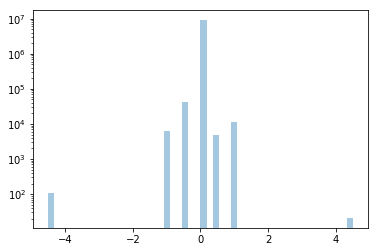

In [141]:
sns.distplot(err,hist_kws={"log":True},kde=False);

In [147]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mean_squared_error(df.calcExtra,df.extra)

0.0035005561500012225

## Check the differences of calculation and real extra. Why does it not match perfectly?

Check all values which are not overnight but still get the 0.5 charge

,time,pickup_time,dropoff_time
count,33902,33902,33902
mean,0 days 18:24:23.039540,0 days 18:18:12.464515,0 days 18:30:33.614565
std,0 days 03:58:12.145757,0 days 03:57:57.645304,0 days 03:58:31.410516
min,0 days 06:00:39,0 days 06:00:00,0 days 06:01:12
25%,0 days 19:43:29.625000,0 days 19:37:45.250000,0 days 19:48:14
50%,0 days 19:58:26,0 days 19:53:13,0 days 20:02:23
75%,0 days 20:03:04,0 days 19:57:42,0 days 20:09:18
max,0 days 21:10:40.500000,0 days 19:59:59,0 days 22:22:37


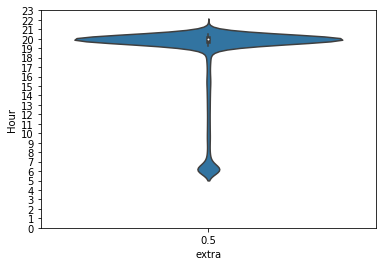

In [54]:
outlier = df[(df.extra == 0.5) & (df.overnight == False)]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(1440,step=60),np.arange(24,step=1))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

There are 14k values wrongfully having a .5 extra cost.
The values range mostly from 19-20, however none was after 20 and so none should have the 0.5 extra cost. The same is true for the bottom, some are right after 6 (Pickup time!), in which case there shouldnt be any tax.

Check the opposite: Values which should have a 0.5 extra, but dont!

,time,pickup_time,dropoff_time
count,19277,19277,19277
mean,0 days 14:18:28.812263,0 days 14:17:16.791046,0 days 14:18:56.013228
std,0 days 07:32:24.017131,0 days 07:30:15.355910,0 days 07:34:44.481321
min,0 days 00:00:07.500000,0 days 00:00:01,0 days 00:00:00
25%,0 days 05:59:44.500000,0 days 05:56:16,0 days 06:02:24
50%,0 days 20:04:43,0 days 20:00:32,0 days 20:07:50
75%,0 days 20:13:12.500000,0 days 20:05:03,0 days 20:21:21
max,0 days 23:59:49.500000,0 days 23:59:54,0 days 23:59:40


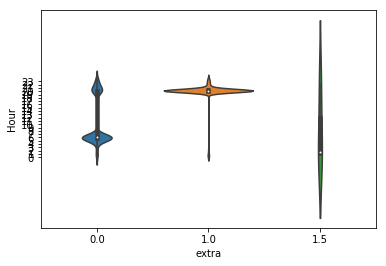

In [55]:
outlier = df[(df.RatecodeID == 1) & (df.extra != 0.5) & (df.overnight == True)]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(1440,step=60),np.arange(24,step=1))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

Most values started before 20, for half the values the mean time is also below 50%, maybe the tax wasn't added then. However, there are many values which cant be correct

In [56]:
outlier.day.value_counts()

Thursday     3612
Wednesday    3380
Friday       2855
Monday       2626
Tuesday      2609
Saturday     2357
Sunday       1838
Name: day, dtype: int64

Check for overnight extra charge!
First check all with extra 1 and outside of an rush hour!

,time,pickup_time,dropoff_time
count,35722,35722,35722
mean,0 days 17:32:58.253933,0 days 17:26:39.854319,0 days 17:39:19.072224
std,0 days 02:19:45.603296,0 days 02:18:05.111160,0 days 02:21:31.800572
min,0 days 00:00:07.500000,0 days 00:00:22,0 days 00:00:20
25%,0 days 16:01:35.625000,0 days 15:55:47,0 days 16:07:09
50%,0 days 16:50:09,0 days 16:44:15,0 days 16:58:55.500000
75%,0 days 19:43:30.625000,0 days 19:37:12.500000,0 days 19:50:00.500000
max,0 days 23:59:18.500000,0 days 23:59:22,0 days 23:59:29


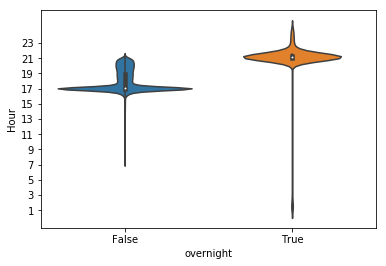

In [57]:
outlier = df[(df.extra ==1) & (df.rush_hour == False) & (df.RatecodeID.isin([1,3,4,5]))]
sns.violinplot(x=outlier.overnight,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(0,1440,step=120),np.arange(1,24,step=2))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

,time,pickup_time,dropoff_time
count,28607,28607,28607
mean,0 days 19:10:56.039273,0 days 19:04:24.855175,0 days 19:17:27.223371
std,0 days 01:27:02.158389,0 days 01:27:35.040023,0 days 01:26:44.450375
min,0 days 16:00:36.500000,0 days 16:00:00,0 days 16:01:03
25%,0 days 19:16:48.500000,0 days 19:10:26.500000,0 days 19:23:11.500000
50%,0 days 19:56:49.500000,0 days 19:51:33,0 days 20:00:51
75%,0 days 20:02:35,0 days 19:57:20,0 days 20:08:25
max,0 days 20:44:55.500000,0 days 19:59:59,0 days 21:45:19


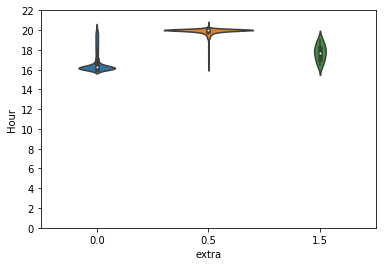

In [59]:
outlier = df[(df.extra != 1) & (df.rush_hour == True) & (df.RatecodeID.isin([1,3,4,5]))]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(0,1440,step=120),np.arange(0,24,step=2))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time','rush_hour']].describe()

# Train model to predict extra more precise

In [88]:
df['workday'] = (df.tpep_pickup_datetime.dt.weekday < 5)&(df.holiday==False)
df['pickup_time_s'] = df['dropoff_time'].astype('timedelta64[s]')
df['duration_s'] = df['duration'].astype('timedelta64[s]')
df['dropoff_time_s'] = df['pickup_time'].astype('timedelta64[s]')
df['weekday'] = df.tpep_pickup_datetime.dt.weekday

In [89]:
df[df.workday==True].day.value_counts()

Thursday     1566260
Wednesday    1517177
Friday       1282174
Tuesday      1184979
Monday       1129632
Sunday             0
Saturday           0
Name: day, dtype: int64

In [90]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
sample = df.sample(100000)

le.fit(sample.extra)
extra_coded = le.transform(sample.extra)

In [91]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(sample[['pickup_time_s','dropoff_time_s','workday']]\
                                                     ,extra_coded, test_size=0.2, random_state=1337)

In [92]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(random_state=1337)

rfr.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

In [93]:
rfr_pred = rfr.predict(X_test)

In [94]:
# Decode
rfr_pred = le.inverse_transform(rfr_pred)
y_test = le.inverse_transform(y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [95]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

,0
count,20000.000000
mean,0.002025
std,0.146831
min,-4.500000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.500000


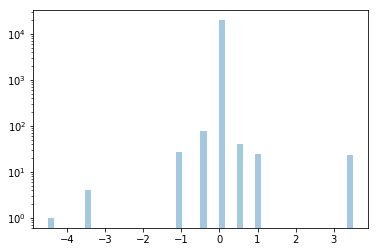

In [96]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [97]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

,Features,estimatedCoefficients
0,pickup_time_s,0.517886
1,dropoff_time_s,0.445313
2,workday,0.036802


In [98]:
rfr_pred

array([0., 0., 0., ..., 1., 0., 1.])

In [99]:
mean_squared_error(rfr_pred,y_test)

0.0215625

# Predict tips amount

In [ ]:
# Load packages
from pygeocoder import Geocoder
import pandas as pd
import numpy as np
import reverse_geocoder as rg


In [158]:
# Payment type 2 doesnt have tips
df['totalWithoutTip'] = df.total_amount-df.tip_amount
#sample = df[df.payment_type!=2].sample(10000)

In [ ]:
pickup_coord = list(zip(df.pickup_latitude, df.pickup_longitude))
dropoff_coord = list(zip(df.dropoff_latitude, df.dropoff_longitude))

In [ ]:
pickup_results = rg.search(pickup_coord) # default mode = 2
dropoff_results = rg.search(dropoff_coord)
df['pickup_area'] = pd.Categorical([d['name'] for d in pickup_results])
df['dropoff_area'] = pd.Categorical([d['name'] for d in dropoff_results])

In [ ]:
import sklearn.preprocessing

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit(sample.pickup_area)
lb.transform(sample.pickup_area)
lb.transform(sample.dropoff_area)

In [ ]:
df.pickup_area.head()

In [ ]:
X_train, X_test, y_train, y_test \
    = train_test_split(sample[['pickup_time_s','dropoff_time_s','weekday','RatecodeID','totalWithoutTip',\
                               'duration_s','trip_distance','pickup_area','dropoff_area']]\
                     ,sample['tip_amount'], test_size=0.2, random_state=1337)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=1337)

rfr.fit(X_train,y_train)

In [ ]:
rfr_pred = rfr.predict(X_test)

In [ ]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

In [ ]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [ ]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

In [ ]:
mean_squared_error(rfr_pred,y_test)

# Exploration

In [137]:
df[df.RatecodeID == 4].extra.value_counts()

0.0    899
0.5    727
1.0    325
Name: extra, dtype: int64

In [155]:
df[df.payment_type==1].tip_amount.value_counts()

1.00     735795
2.00     382266
0.00     251545
1.50     162741
3.00     119950
1.95      96478
1.66      96033
1.76      94033
1.86      91699
1.45      90129
1.36      89601
1.20      84635
2.45      81079
1.26      80793
1.70      79929
2.16      77839
1.25      77567
1.75      74453
1.85      73575
2.26      71729
2.36      66549
1.16      65412
1.35      63630
2.20      56458
2.25      54672
2.66      52431
2.95      50942
2.76      47859
2.35      47722
5.00      47389
          ...  
6.47          1
9.11          1
9.91          1
7.72          1
9.03          1
8.41          1
9.37          1
7.97          1
12.23         1
8.84          1
7.22          1
9.41          1
9.13          1
9.34          1
9.59          1
12.03         1
6.03          1
9.14          1
13.76         1
10.41         1
7.94          1
10.34         1
6.97          1
7.79          1
6.11          1
12.72         1
11.09         1
13.22         1
13.72         1
7.41          1
Name: tip_amount, Length

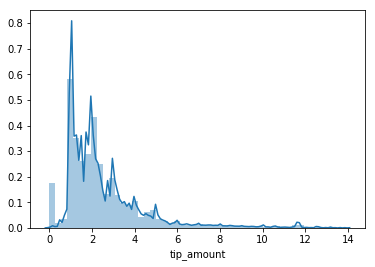

In [157]:
sns.distplot(df[df.payment_type==1].tip_amount)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078486 entries, 0 to 11135469
Data columns (total 32 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               category
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
total_amount             float64
duration                 timedelta64[ns]
day                      category
holiday                  bool
meanDate                 datetime64[ns]
time                     timedelta64[ns]
pickup_time              timedelta64[ns]
dropoff_time             timedelta64[ns]
workday                  bool
pickup_time_s            float64
duration_s      

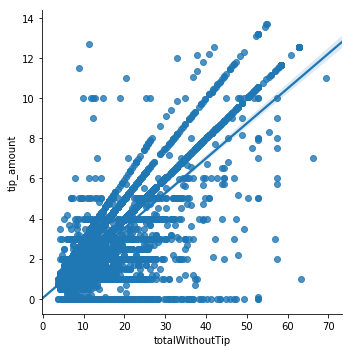

In [169]:
sample = df[df.payment_type==1].sample(10000)
sns.lmplot(y='tip_amount',x='totalWithoutTip', data=sample)

tipping is mostly categorical:
* Fixed sum
    * $0,$1,$2,$3,$4,$5... depending on the total. Round to the next full dollar, with around 20% tips
* Fixed percentage
    * There are 3 clear lines
        * lowest and biggest equals 20% tip
        * middle equals 24% tip
        * highest equals 26 % tip?
        
total regression is below the 20% line however
* Due to many 0 tippers around all ranges
* Many low tipper with fixed amount


### Predict 0 tippers
### Predict fixed tippers?
### Calculate regression w/ 0 tippers, use as base?

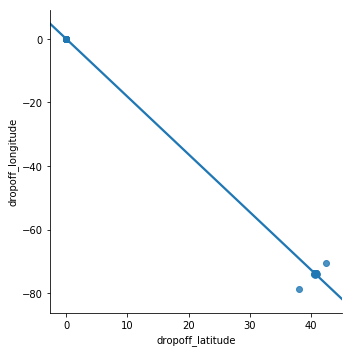

In [186]:
sns.lmplot(y='dropoff_longitude',x='dropoff_latitude', data=sample)

In [ ]:
a = sns.distplot(df.time.astype('timedelta64[m]'))
plt.xticks(np.arange(1440,step=180),np.arange(24,step=3))
plt.xlabel('Hour')

In [ ]:
sns.violinplot(x=df.extra,y=df.time.astype('timedelta64[m]'))

In [ ]:
df.mta_tax.value_counts t()

sns.distplot(df.duration.astype('timedelta64[m]'))

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(2,3,1)
sns.countplot(df.extra)
plt.subplot(2,3,2)
sns.countplot(df.overnight)
plt.subplot(2,3,3)
sns.countplot(df.rush_hour)
plt.subplot(2,3,4)
sns.countplot(df.day)
plt.subplot(2,3,5)
sns.countplot(df.passenger_count)
plt.subplot(2,3,6)
sns.countplot(df.RatecodeID)

In [173]:
sample["duration_m"] = sample.duration.astype('timedelta64[m]')

In [ ]:
sns.lmplot(x="trip_distance", y="duration_m",hue="RatecodeID", data=df.sample(10000))

In [ ]:
df.RatecodeID.value_counts()

# Check Test Data

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.info()

In [ ]:
test.describe()

In [ ]:
test['duration'] = pd.to_datetime(test["tpep_dropoff_datetime"])-pd.to_datetime(test["tpep_pickup_datetime"])

In [ ]:
test[pd.to_datetime(test["tpep_pickup_datetime"]).dt.day != pd.to_datetime(test["tpep_dropoff_datetime"]).dt.day].duration.describe()

In [ ]:
test[test.duration > "2 hours"].RatecodeID.value_counts()

In [ ]:
sns.countplot(test["RatecodeID"])

In [ ]:
sns.countplot(df["extra"])

In [ ]:
sns.countplot(df[df.RatecodeID == 6].extra)

In [ ]:
df[df.mta_tax == 0].RatecodeID.value_counts()

In [ ]:
sns.distplot(df.trip_distance)

In [ ]:
sns.distplot(test.trip_distance)

In [ ]:
sns.distplot(test.duration)

## Notes 

* *improvement_surgcharge* should be constant. Minimum seems to be a sign error. Maximum seems to be a outlier (mistake??)


In [ ]:
df.info()

In [ ]:
df = df.drop(['VendorID','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','Holiday','improvement_surcharge','mta_tax','store_and_fwd_flag','payment_type','duration_m'],axis=1)

In [ ]:
df=df.drop('total',axis=1)

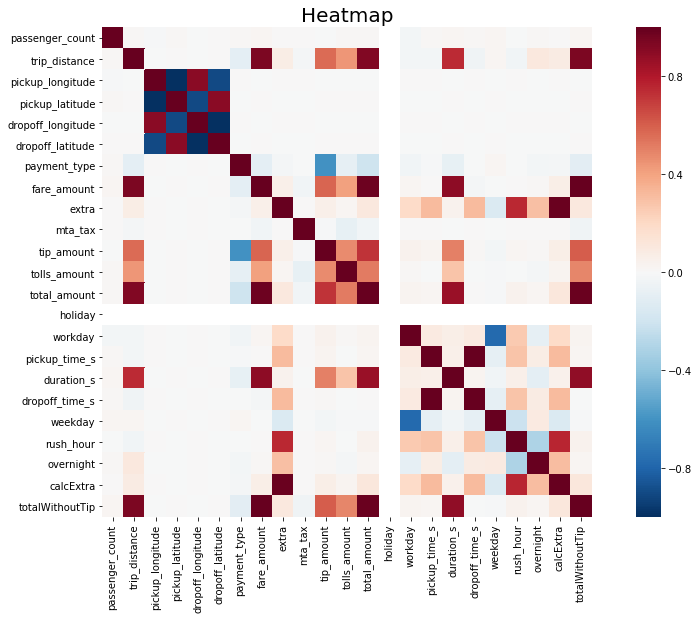

In [170]:
corr = df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1).corr()

plt.figure(figsize=(16,9))

plt.title("Heatmap",fontsize=20)
sns.heatmap(corr, cmap="RdBu_r", square=True)

In [ ]:
sns.distplot(df['total_amount'], hist=True)

In [ ]:
sample = df.sample(10000)

In [ ]:
sns.lmplot(x='extra',y='Overnight',hue='RushHour',data=sample)

In [ ]:
sns.jointplot(x='total_amount',y='fare_amount',data=df, kind='hex')

In [ ]:
sns.lmplot(x='total_amount',y='tip_amount',hue='extra',data=sample)

In [ ]:
sns.lmplot(x='improvement_surcharge',y='mta_tax',data=sample)